In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
import sys

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


Using TensorFlow backend.
/home/greed/anaconda3/envs/tensorflow_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/greed/anaconda3/envs/tensorflow_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/greed/anaconda3/envs/tensorflow_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [2]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	print(diff_series)
	#sys.exit(1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, 
                   batch_input_shape=(n_batch, X.shape[1], X.shape[2]), 
                   stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        model.reset_states()
        print(i)
    return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

In [16]:
series = read_csv('db_seq.txt', header=0, parse_dates=[0], index_col=0, squeeze=True)
print(series)

1
2         0
3         0
4         0
5         0
6        18
       ... 
1041      5
1042      0
1043      0
1044    200
1045      0
Name: 7, Length: 1044, dtype: int64


In [10]:
# configure
n_lag = 1
n_seq = 3
n_test = 100
n_epochs = 1500
n_batch = 1
n_neurons = 1
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)


0         0
1         0
2         0
3        18
4       -10
       ... 
1038      5
1039     -5
1040      0
1041    200
1042   -200
Length: 1043, dtype: int64


In [17]:
print(type(test))
for rec in test:
    print(rec)
    print(type(rec))

<class 'numpy.ndarray'>
[ 0.    0.06 -0.06  0.  ]
<class 'numpy.ndarray'>
[ 0.06 -0.06  0.    0.  ]
<class 'numpy.ndarray'>
[-0.06  0.    0.    0.  ]
<class 'numpy.ndarray'>
[0. 0. 0. 0.]
<class 'numpy.ndarray'>
[0. 0. 0. 0.]
<class 'numpy.ndarray'>
[0. 0. 0. 0.]
<class 'numpy.ndarray'>
[0. 0. 0. 0.]
<class 'numpy.ndarray'>
[0. 0. 0. 0.]
<class 'numpy.ndarray'>
[0. 0. 0. 0.]
<class 'numpy.ndarray'>
[0.   0.   0.   0.04]
<class 'numpy.ndarray'>
[ 0.    0.    0.04 -0.04]
<class 'numpy.ndarray'>
[ 0.    0.04 -0.04  0.  ]
<class 'numpy.ndarray'>
[ 0.04 -0.04  0.    0.  ]
<class 'numpy.ndarray'>
[-0.04  0.    0.    0.  ]
<class 'numpy.ndarray'>
[0. 0. 0. 0.]
<class 'numpy.ndarray'>
[0. 0. 0. 0.]
<class 'numpy.ndarray'>
[0.  0.  0.  0.6]
<class 'numpy.ndarray'>
[ 0.   0.   0.6 -0.6]
<class 'numpy.ndarray'>
[ 0.   0.6 -0.6  0. ]
<class 'numpy.ndarray'>
[ 0.6 -0.6  0.   0. ]
<class 'numpy.ndarray'>
[-0.6  0.   0.   0. ]
<class 'numpy.ndarray'>
[0. 0. 0. 0.]
<class 'numpy.ndarray'>
[0. 0. 0. 0.

In [6]:
# fit model
print(train)
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

[[ 0.     0.     0.     0.072]
 [ 0.     0.     0.072 -0.04 ]
 [ 0.     0.072 -0.04  -0.012]
 ...
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.06 ]
 [ 0.     0.     0.06  -0.06 ]]

Epoch 1/1
940/940 [==============================] - 3s 3ms/step - loss: 0.0106
0
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0105
1
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0103
2
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0101
3
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0098
4
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0096
5
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0094
6
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0092
7
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0091
8
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - lo

940/940 [==============================] - 2s 2ms/step - loss: 0.0090
190
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
191
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
192
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
193
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
194
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
195
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
196
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
197
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
198
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
199
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
200
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
201
Ep

940/940 [==============================] - 2s 2ms/step - loss: 0.0090
384
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
385
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
386
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
387
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
388
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
389
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
390
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
391
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
392
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
393
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
394
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
395
Ep

940/940 [==============================] - 2s 2ms/step - loss: 0.0090
578
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
579
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
580
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
581
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
582
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
583
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
584
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
585
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
586
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
587
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
588
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0090
589
Ep

940/940 [==============================] - 2s 2ms/step - loss: 0.0089
772
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
773
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
774
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
775
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
776
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
777
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
778
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
779
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
780
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
781
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
782
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
783
Ep

940/940 [==============================] - 2s 2ms/step - loss: 0.0089
966
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
967
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
968
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
969
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
970
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
971
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
972
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
973
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
974
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
975
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
976
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
977
Ep

940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1158
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1159
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1160
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1161
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1162
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1163
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1164
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1165
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1166
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1167
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1168
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.

940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1350
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1351
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1352
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1353
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1354
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1355
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1356
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1357
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1358
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1359
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0089
1360
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.

In [7]:
model.save("model.lstm")
print("Saved model to disk")

Saved model to disk


In [8]:
print(model)

In [7]:
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

NameError: name 'train' is not defined

t+1 RMSE: 24.495946
t+2 RMSE: 31.364115
t+3 RMSE: 31.483855


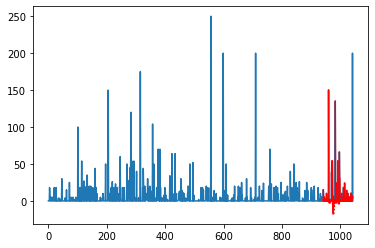

In [10]:
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)

In [11]:
# univariate data preparation
from numpy import array
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        #gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 
# define input sequence
#raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
raw_seq=d
# choose a number of time steps
n_steps = 20
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
XTest=[]
YTest=[]
for i in range(len(X)):
    if i>250:
        #print(i, X[i], y[i])
        XTest.append(X[i])
        YTest.append(y[i])

print(X.shape[0], X.shape[1], n_features)
print(X[0])

329 20 1
[0.04997917 0.09983342 0.14943813 0.19866933 0.24740396 0.29552021
 0.34289781 0.38941834 0.43496553 0.47942554 0.52268723 0.56464247
 0.60518641 0.64421769 0.68163876 0.71735609 0.75128041 0.78332691
 0.8134155  0.84147098]


In [9]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
n_batch = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
#print('x', X)
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [6]:
model.fit(X, y, epochs=2000, verbose=1)


Epoch 1/2000


KeyboardInterrupt: 

In [282]:
loss = model.evaluate(X[:1000], y[:1000], verbose=1)
print("loss {0:8.6f}%".format(loss*100))

229/229 [==============================] - 0s 460us/step
loss 0.000062%


In [285]:
#forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
YPred=[]
x_input = array([[31.59482679, 31.52298863, 30.8783776,  30.52946472, 31.0728575, \
                  32.28478174, 33.32681851, 33.51674261, 32.95575732, 32.43544855, \
                  32.7100044,  33.80281809, 34.98498039, 35.44543533, 35.03666139, \
                  34.41030206, 34.41804783, 35.3285959, 36.58061118, 37.29881522]])
for rec in range(0, len(XTest)):
    x_input = XTest[rec]
    n_steps_in=20
    n_features=1
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    YPred.append(yhat)

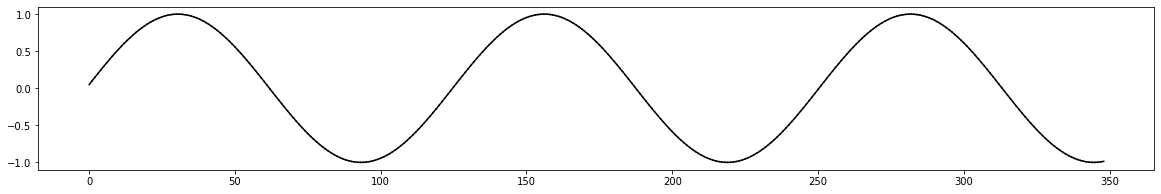

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines

%matplotlib inline

Ypred=[]
d=[]
for i in range(1,350):
    #y=np.sin(i)*np.sin(i*20)*0.2+np.sin(i/10)*0.3
    #y=np.sin(i/20)*0.3+np.sin(i*40)*0.1*np.sin(i*40)
    y=np.sin(i/20)
    d.append(y)
###############################
#x, y = np.random.random(size=(2,10))

fig = plt.figure(figsize=(20, 3))
for i in range(0, len(d)-1):
    x1, x2 = i, i+1
    y1, y2 = d[i], d[i+1]
    #print('#', x1, x2, y1, y2)
    plt.plot([x1,x2],[y1,y2],'k-')

if len(Ypred)>0:
    for j in range(0, len(YPred)-1):
        #print(XTest[j][0], YPred[j])
        x1, x2 = j+250, j+1+250
        y1, y2 = YPred[j][0][0], YPred[j+1][0][0]
        #print(x1, x2, y1, y2)
        plt.plot([x1,x2],[y1,y2],color='red')
plt.show()